<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:15:34] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


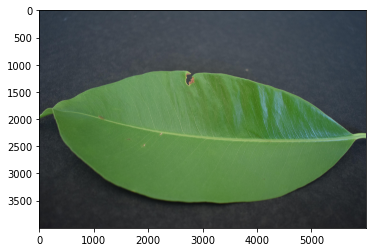

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

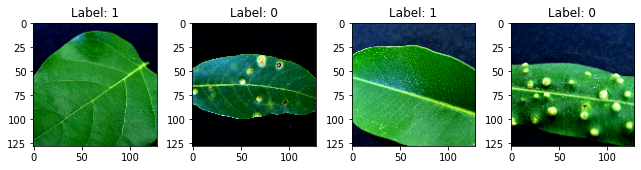

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:15:41] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:15:43] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2897231063100372 samples/sec                   batch loss = 1.174021601676941 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2948918690065134 samples/sec                   batch loss = 0.8180140256881714 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2994108618103595 samples/sec                   batch loss = 0.9322217702865601 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2983160105523093 samples/sec                   batch loss = 0.4564175605773926 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.3069227767135954 samples/sec                   batch loss = 0.5537471175193787 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2832075293184708 samples/sec                   batch loss = 0.7047361731529236 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.285308940178859 samples/sec                   batch loss = 0.6839082837104797 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.293180731184586 samples/sec                   batch loss = 0.31246939301490784 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2936821056003291 samples/sec                   batch loss = 0.8178312182426453 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2929943605147403 samples/sec                   batch loss = 0.34755170345306396 | accuracy = 0.55


Epoch[1] Batch[55] Speed: 1.2895623123367794 samples/sec                   batch loss = 1.0567481517791748 | accuracy = 0.5545454545454546


Epoch[1] Batch[60] Speed: 1.2969852303910718 samples/sec                   batch loss = 0.38794615864753723 | accuracy = 0.5666666666666667


Epoch[1] Batch[65] Speed: 1.300727264410484 samples/sec                   batch loss = 0.5222221612930298 | accuracy = 0.5653846153846154


Epoch[1] Batch[70] Speed: 1.30259890641176 samples/sec                   batch loss = 1.076160192489624 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.3049299848780342 samples/sec                   batch loss = 0.4674344062805176 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2967081566198004 samples/sec                   batch loss = 1.712921380996704 | accuracy = 0.5875


Epoch[1] Batch[85] Speed: 1.29587414186229 samples/sec                   batch loss = 0.5139607191085815 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2903858378574196 samples/sec                   batch loss = 0.8823285102844238 | accuracy = 0.6027777777777777


Epoch[1] Batch[95] Speed: 1.301295973891578 samples/sec                   batch loss = 0.5940515398979187 | accuracy = 0.6078947368421053


Epoch[1] Batch[100] Speed: 1.3001026306107033 samples/sec                   batch loss = 0.7790678143501282 | accuracy = 0.5975


Epoch[1] Batch[105] Speed: 1.2993842932430253 samples/sec                   batch loss = 0.5765787363052368 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.3041750788775952 samples/sec                   batch loss = 0.9799253940582275 | accuracy = 0.6045454545454545


Epoch[1] Batch[115] Speed: 1.2925322535688053 samples/sec                   batch loss = 0.5578354001045227 | accuracy = 0.6108695652173913


Epoch[1] Batch[120] Speed: 1.2956829915318704 samples/sec                   batch loss = 0.5986913442611694 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.289966653672594 samples/sec                   batch loss = 0.9377986192703247 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.287927012318786 samples/sec                   batch loss = 0.3239140510559082 | accuracy = 0.6230769230769231


Epoch[1] Batch[135] Speed: 1.2830225502247496 samples/sec                   batch loss = 0.9250699281692505 | accuracy = 0.6240740740740741


Epoch[1] Batch[140] Speed: 1.287405390120555 samples/sec                   batch loss = 1.4033468961715698 | accuracy = 0.6303571428571428


Epoch[1] Batch[145] Speed: 1.303094352929206 samples/sec                   batch loss = 0.6319447159767151 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.3054587970698714 samples/sec                   batch loss = 0.3745473325252533 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.2986816271542883 samples/sec                   batch loss = 1.6612776517868042 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.2869849805869287 samples/sec                   batch loss = 0.45071280002593994 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.2898606358007716 samples/sec                   batch loss = 1.217127799987793 | accuracy = 0.6333333333333333


Epoch[1] Batch[170] Speed: 1.2930021331909922 samples/sec                   batch loss = 0.36731696128845215 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.2901347907047205 samples/sec                   batch loss = 1.1285150051116943 | accuracy = 0.6314285714285715


Epoch[1] Batch[180] Speed: 1.2868799457794609 samples/sec                   batch loss = 0.39868104457855225 | accuracy = 0.6361111111111111


Epoch[1] Batch[185] Speed: 1.280967038638865 samples/sec                   batch loss = 0.434265673160553 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.294022459874405 samples/sec                   batch loss = 0.5201058387756348 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.282264350177705 samples/sec                   batch loss = 0.3149089813232422 | accuracy = 0.6487179487179487


Epoch[1] Batch[200] Speed: 1.2713768461894044 samples/sec                   batch loss = 0.3870832622051239 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.270560462397173 samples/sec                   batch loss = 0.35146310925483704 | accuracy = 0.6524390243902439


Epoch[1] Batch[210] Speed: 1.2691008297726298 samples/sec                   batch loss = 0.279389351606369 | accuracy = 0.6547619047619048


Epoch[1] Batch[215] Speed: 1.2772335311927367 samples/sec                   batch loss = 0.4056766927242279 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.2683623458254996 samples/sec                   batch loss = 0.6259242296218872 | accuracy = 0.6613636363636364


Epoch[1] Batch[225] Speed: 1.2499075078862285 samples/sec                   batch loss = 1.3765817880630493 | accuracy = 0.66


Epoch[1] Batch[230] Speed: 1.248316371990067 samples/sec                   batch loss = 0.8566059470176697 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.2534180360177665 samples/sec                   batch loss = 0.7837757468223572 | accuracy = 0.6553191489361702


Epoch[1] Batch[240] Speed: 1.2682580276554856 samples/sec                   batch loss = 0.7251636385917664 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2671754941067317 samples/sec                   batch loss = 0.5356730818748474 | accuracy = 0.6540816326530612


Epoch[1] Batch[250] Speed: 1.2651858619845313 samples/sec                   batch loss = 0.6188145875930786 | accuracy = 0.653


Epoch[1] Batch[255] Speed: 1.267464314543469 samples/sec                   batch loss = 0.4983341693878174 | accuracy = 0.653921568627451


Epoch[1] Batch[260] Speed: 1.2718943324672454 samples/sec                   batch loss = 0.6487007737159729 | accuracy = 0.6538461538461539


Epoch[1] Batch[265] Speed: 1.274502134309692 samples/sec                   batch loss = 0.3845878541469574 | accuracy = 0.6537735849056604


Epoch[1] Batch[270] Speed: 1.2623264473962303 samples/sec                   batch loss = 0.4586641490459442 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.2620122430987768 samples/sec                   batch loss = 0.7612835764884949 | accuracy = 0.6518181818181819


Epoch[1] Batch[280] Speed: 1.253758986639198 samples/sec                   batch loss = 0.5361801385879517 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.2552523595627345 samples/sec                   batch loss = 0.6917058229446411 | accuracy = 0.6543859649122807


Epoch[1] Batch[290] Speed: 1.2580744023286188 samples/sec                   batch loss = 0.9387390613555908 | accuracy = 0.653448275862069


Epoch[1] Batch[295] Speed: 1.2565569001663903 samples/sec                   batch loss = 0.5082238912582397 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2628676745942704 samples/sec                   batch loss = 0.40261614322662354 | accuracy = 0.6591666666666667


Epoch[1] Batch[305] Speed: 1.2693864948004399 samples/sec                   batch loss = 0.3949413001537323 | accuracy = 0.6614754098360656


Epoch[1] Batch[310] Speed: 1.2700230057651807 samples/sec                   batch loss = 1.2011371850967407 | accuracy = 0.6588709677419354


Epoch[1] Batch[315] Speed: 1.2671910948965643 samples/sec                   batch loss = 0.37706729769706726 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.2549616612166261 samples/sec                   batch loss = 0.21445748209953308 | accuracy = 0.6609375


Epoch[1] Batch[325] Speed: 1.2555187634665133 samples/sec                   batch loss = 0.8873754143714905 | accuracy = 0.6623076923076923


Epoch[1] Batch[330] Speed: 1.2602477661631624 samples/sec                   batch loss = 0.9187135696411133 | accuracy = 0.6628787878787878


Epoch[1] Batch[335] Speed: 1.266718073652928 samples/sec                   batch loss = 0.2932550013065338 | accuracy = 0.664179104477612


Epoch[1] Batch[340] Speed: 1.2666429049922845 samples/sec                   batch loss = 0.33781853318214417 | accuracy = 0.6661764705882353


Epoch[1] Batch[345] Speed: 1.2679220825546687 samples/sec                   batch loss = 0.6184535026550293 | accuracy = 0.6666666666666666


Epoch[1] Batch[350] Speed: 1.2649429976237292 samples/sec                   batch loss = 0.7527526021003723 | accuracy = 0.6671428571428571


Epoch[1] Batch[355] Speed: 1.2638135597305988 samples/sec                   batch loss = 0.3183119595050812 | accuracy = 0.6704225352112676


Epoch[1] Batch[360] Speed: 1.2563549685402342 samples/sec                   batch loss = 0.6280941963195801 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2521679422414465 samples/sec                   batch loss = 0.5288808941841125 | accuracy = 0.6691780821917809


Epoch[1] Batch[370] Speed: 1.2557132834148135 samples/sec                   batch loss = 1.013093113899231 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.256153101805417 samples/sec                   batch loss = 0.6983042359352112 | accuracy = 0.6746666666666666


Epoch[1] Batch[380] Speed: 1.258844682535794 samples/sec                   batch loss = 0.3986261785030365 | accuracy = 0.675


Epoch[1] Batch[385] Speed: 1.2552758391430026 samples/sec                   batch loss = 1.025019645690918 | accuracy = 0.6733766233766234


Epoch[1] Batch[390] Speed: 1.2510423478758206 samples/sec                   batch loss = 0.8323245048522949 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.263048028331902 samples/sec                   batch loss = 0.29270753264427185 | accuracy = 0.6759493670886076


Epoch[1] Batch[400] Speed: 1.2617870124627033 samples/sec                   batch loss = 1.0245646238327026 | accuracy = 0.675625


Epoch[1] Batch[405] Speed: 1.2642573568929134 samples/sec                   batch loss = 0.4485803246498108 | accuracy = 0.6765432098765433


Epoch[1] Batch[410] Speed: 1.2662197935145656 samples/sec                   batch loss = 0.8589162826538086 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.251810763449238 samples/sec                   batch loss = 0.6958920955657959 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.253120698685155 samples/sec                   batch loss = 0.42302995920181274 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2522147652409301 samples/sec                   batch loss = 0.6481092572212219 | accuracy = 0.6770588235294117


Epoch[1] Batch[430] Speed: 1.2678475374209335 samples/sec                   batch loss = 0.9743872284889221 | accuracy = 0.6784883720930233


Epoch[1] Batch[435] Speed: 1.269239469276055 samples/sec                   batch loss = 0.7420671582221985 | accuracy = 0.6798850574712644


Epoch[1] Batch[440] Speed: 1.2669655429380022 samples/sec                   batch loss = 0.9550179243087769 | accuracy = 0.68125


Epoch[1] Batch[445] Speed: 1.2598765026032257 samples/sec                   batch loss = 0.19277352094650269 | accuracy = 0.6820224719101123


Epoch[1] Batch[450] Speed: 1.2629163469645797 samples/sec                   batch loss = 0.36891770362854004 | accuracy = 0.6816666666666666


Epoch[1] Batch[455] Speed: 1.2598528506009625 samples/sec                   batch loss = 0.33805522322654724 | accuracy = 0.6824175824175824


Epoch[1] Batch[460] Speed: 1.2493466277532632 samples/sec                   batch loss = 0.34332823753356934 | accuracy = 0.6831521739130435


Epoch[1] Batch[465] Speed: 1.2505687193087427 samples/sec                   batch loss = 0.6278188228607178 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.253408952782346 samples/sec                   batch loss = 0.3717019855976105 | accuracy = 0.6845744680851064


Epoch[1] Batch[475] Speed: 1.2663409813748299 samples/sec                   batch loss = 0.2939634323120117 | accuracy = 0.6852631578947368


Epoch[1] Batch[480] Speed: 1.2738869520940543 samples/sec                   batch loss = 0.27627792954444885 | accuracy = 0.6859375


Epoch[1] Batch[485] Speed: 1.2671889892460644 samples/sec                   batch loss = 0.27400726079940796 | accuracy = 0.6876288659793814


Epoch[1] Batch[490] Speed: 1.2606382878803328 samples/sec                   batch loss = 0.18848086893558502 | accuracy = 0.6887755102040817


Epoch[1] Batch[495] Speed: 1.2495994547922606 samples/sec                   batch loss = 0.41000765562057495 | accuracy = 0.6878787878787879


Epoch[1] Batch[500] Speed: 1.2438025483500978 samples/sec                   batch loss = 0.4895881116390228 | accuracy = 0.6865


Epoch[1] Batch[505] Speed: 1.2480179220713334 samples/sec                   batch loss = 0.5209659934043884 | accuracy = 0.6861386138613862


Epoch[1] Batch[510] Speed: 1.2494694459239981 samples/sec                   batch loss = 0.47217193245887756 | accuracy = 0.6852941176470588


Epoch[1] Batch[515] Speed: 1.2536777598695121 samples/sec                   batch loss = 0.9635058641433716 | accuracy = 0.6849514563106797


Epoch[1] Batch[520] Speed: 1.2572042526332796 samples/sec                   batch loss = 0.5418450832366943 | accuracy = 0.6860576923076923


Epoch[1] Batch[525] Speed: 1.2673982485396629 samples/sec                   batch loss = 0.43354684114456177 | accuracy = 0.6857142857142857


Epoch[1] Batch[530] Speed: 1.2707917240309476 samples/sec                   batch loss = 0.4431345760822296 | accuracy = 0.6858490566037736


Epoch[1] Batch[535] Speed: 1.2709857099470225 samples/sec                   batch loss = 0.30685460567474365 | accuracy = 0.685981308411215


Epoch[1] Batch[540] Speed: 1.26980249932242 samples/sec                   batch loss = 0.4401092827320099 | accuracy = 0.687037037037037


Epoch[1] Batch[545] Speed: 1.2675940729010207 samples/sec                   batch loss = 0.5188908576965332 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.2666363066426847 samples/sec                   batch loss = 0.7496573328971863 | accuracy = 0.6872727272727273


Epoch[1] Batch[555] Speed: 1.2571704325593733 samples/sec                   batch loss = 0.3621353805065155 | accuracy = 0.6869369369369369


Epoch[1] Batch[560] Speed: 1.2601526344639984 samples/sec                   batch loss = 0.598507821559906 | accuracy = 0.6861607142857142


Epoch[1] Batch[565] Speed: 1.2560106300986642 samples/sec                   batch loss = 0.5000948905944824 | accuracy = 0.6880530973451328


Epoch[1] Batch[570] Speed: 1.270667661859974 samples/sec                   batch loss = 0.6400527954101562 | accuracy = 0.6868421052631579


Epoch[1] Batch[575] Speed: 1.2719369530114162 samples/sec                   batch loss = 0.841976523399353 | accuracy = 0.6865217391304348


Epoch[1] Batch[580] Speed: 1.269049375725305 samples/sec                   batch loss = 0.33245518803596497 | accuracy = 0.6875


Epoch[1] Batch[585] Speed: 1.2702936970257173 samples/sec                   batch loss = 0.399148166179657 | accuracy = 0.6871794871794872


Epoch[1] Batch[590] Speed: 1.2731956419735257 samples/sec                   batch loss = 0.6226184368133545 | accuracy = 0.686864406779661


Epoch[1] Batch[595] Speed: 1.2651488444250427 samples/sec                   batch loss = 0.23841282725334167 | accuracy = 0.6890756302521008


Epoch[1] Batch[600] Speed: 1.2594138414983116 samples/sec                   batch loss = 0.39679160714149475 | accuracy = 0.6879166666666666


Epoch[1] Batch[605] Speed: 1.2586656215557723 samples/sec                   batch loss = 0.6237611174583435 | accuracy = 0.6884297520661157


Epoch[1] Batch[610] Speed: 1.26377186262524 samples/sec                   batch loss = 0.7934651374816895 | accuracy = 0.6881147540983606


Epoch[1] Batch[615] Speed: 1.259775940428991 samples/sec                   batch loss = 0.17443528771400452 | accuracy = 0.6886178861788618


Epoch[1] Batch[620] Speed: 1.2577133750326757 samples/sec                   batch loss = 0.5930081009864807 | accuracy = 0.6879032258064516


Epoch[1] Batch[625] Speed: 1.2567912824439673 samples/sec                   batch loss = 0.5053002238273621 | accuracy = 0.6884


Epoch[1] Batch[630] Speed: 1.263997612019282 samples/sec                   batch loss = 0.3385426998138428 | accuracy = 0.6892857142857143


Epoch[1] Batch[635] Speed: 1.2713244367280045 samples/sec                   batch loss = 0.5039852857589722 | accuracy = 0.6893700787401574


Epoch[1] Batch[640] Speed: 1.2767791212734294 samples/sec                   batch loss = 0.27867791056632996 | accuracy = 0.690625


Epoch[1] Batch[645] Speed: 1.2801359519382551 samples/sec                   batch loss = 0.19547347724437714 | accuracy = 0.6910852713178295


Epoch[1] Batch[650] Speed: 1.266145257299184 samples/sec                   batch loss = 0.07537796348333359 | accuracy = 0.6923076923076923


Epoch[1] Batch[655] Speed: 1.256416500938949 samples/sec                   batch loss = 0.29007214307785034 | accuracy = 0.6942748091603054


Epoch[1] Batch[660] Speed: 1.25558228122825 samples/sec                   batch loss = 1.2774745225906372 | accuracy = 0.6943181818181818


Epoch[1] Batch[665] Speed: 1.2669403802614785 samples/sec                   batch loss = 0.7876999974250793 | accuracy = 0.6943609022556391


Epoch[1] Batch[670] Speed: 1.2734780304147604 samples/sec                   batch loss = 0.23437361419200897 | accuracy = 0.6951492537313433


Epoch[1] Batch[675] Speed: 1.2729177247622672 samples/sec                   batch loss = 0.4166998863220215 | accuracy = 0.6948148148148148


Epoch[1] Batch[680] Speed: 1.2696996737662325 samples/sec                   batch loss = 0.3328797519207001 | accuracy = 0.6948529411764706


Epoch[1] Batch[685] Speed: 1.2740473434970276 samples/sec                   batch loss = 1.619382381439209 | accuracy = 0.6956204379562044


Epoch[1] Batch[690] Speed: 1.2693477904614248 samples/sec                   batch loss = 0.08031675964593887 | accuracy = 0.6971014492753623


Epoch[1] Batch[695] Speed: 1.2706315738451843 samples/sec                   batch loss = 0.5503777265548706 | accuracy = 0.6960431654676259


Epoch[1] Batch[700] Speed: 1.2609599587046003 samples/sec                   batch loss = 0.6040991544723511 | accuracy = 0.6960714285714286


Epoch[1] Batch[705] Speed: 1.260857233598959 samples/sec                   batch loss = 0.2889082729816437 | accuracy = 0.6957446808510638


Epoch[1] Batch[710] Speed: 1.2619034617544451 samples/sec                   batch loss = 0.3428930938243866 | accuracy = 0.6971830985915493


Epoch[1] Batch[715] Speed: 1.2700274282120505 samples/sec                   batch loss = 0.7339912056922913 | accuracy = 0.6961538461538461


Epoch[1] Batch[720] Speed: 1.2741664539539093 samples/sec                   batch loss = 0.26224833726882935 | accuracy = 0.6972222222222222


Epoch[1] Batch[725] Speed: 1.2689550221479984 samples/sec                   batch loss = 0.7127832174301147 | accuracy = 0.6968965517241379


Epoch[1] Batch[730] Speed: 1.2617079682634558 samples/sec                   batch loss = 0.14762595295906067 | accuracy = 0.6972602739726027


Epoch[1] Batch[735] Speed: 1.2587132150731837 samples/sec                   batch loss = 0.4381585419178009 | accuracy = 0.6965986394557823


Epoch[1] Batch[740] Speed: 1.2537754768649754 samples/sec                   batch loss = 0.2848394215106964 | accuracy = 0.6962837837837837


Epoch[1] Batch[745] Speed: 1.25644143550761 samples/sec                   batch loss = 0.6457061171531677 | accuracy = 0.6959731543624161


Epoch[1] Batch[750] Speed: 1.2495148575435853 samples/sec                   batch loss = 0.5543226599693298 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.259639360516577 samples/sec                   batch loss = 0.868722140789032 | accuracy = 0.6950331125827814


Epoch[1] Batch[760] Speed: 1.2735532391461102 samples/sec                   batch loss = 1.5976518392562866 | accuracy = 0.6950657894736842


Epoch[1] Batch[765] Speed: 1.2753810833248636 samples/sec                   batch loss = 0.3648436963558197 | accuracy = 0.6954248366013072


Epoch[1] Batch[770] Speed: 1.2792007922906443 samples/sec                   batch loss = 0.441020667552948 | accuracy = 0.6957792207792208


Epoch[1] Batch[775] Speed: 1.2734167486340187 samples/sec                   batch loss = 0.33005985617637634 | accuracy = 0.6964516129032258


Epoch[1] Batch[780] Speed: 1.2707529339532828 samples/sec                   batch loss = 0.8690980672836304 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.2729264168929433 samples/sec                   batch loss = 1.1670888662338257 | accuracy = 0.695859872611465


[Epoch 1] training: accuracy=0.6954314720812182
[Epoch 1] time cost: 648.4050090312958
[Epoch 1] validation: validation accuracy=0.7577777777777778


Epoch[2] Batch[5] Speed: 1.2539501499757988 samples/sec                   batch loss = 0.29736560583114624 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2525903170049733 samples/sec                   batch loss = 0.8330277800559998 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.257246271192855 samples/sec                   batch loss = 0.37808316946029663 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2714758000959905 samples/sec                   batch loss = 0.9092411398887634 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2694308684355542 samples/sec                   batch loss = 0.6580225229263306 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2701485767773617 samples/sec                   batch loss = 0.4122309684753418 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2694114665943734 samples/sec                   batch loss = 0.6011079549789429 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2720025286572179 samples/sec                   batch loss = 0.27375733852386475 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2730346921578901 samples/sec                   batch loss = 0.6246618032455444 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.2537666695313288 samples/sec                   batch loss = 0.346804141998291 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.2562819654385757 samples/sec                   batch loss = 0.39554184675216675 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.2524258393093464 samples/sec                   batch loss = 0.4214939475059509 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2639376201288421 samples/sec                   batch loss = 0.8809534907341003 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2643572065699606 samples/sec                   batch loss = 0.5037250518798828 | accuracy = 0.7714285714285715


Epoch[2] Batch[75] Speed: 1.2633676005240457 samples/sec                   batch loss = 0.311806857585907 | accuracy = 0.77


Epoch[2] Batch[80] Speed: 1.2698774667659627 samples/sec                   batch loss = 0.255132794380188 | accuracy = 0.7625


Epoch[2] Batch[85] Speed: 1.2707544739608514 samples/sec                   batch loss = 0.1260175257921219 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.2773020852485575 samples/sec                   batch loss = 1.048486351966858 | accuracy = 0.7583333333333333


Epoch[2] Batch[95] Speed: 1.2626776791233907 samples/sec                   batch loss = 0.6461192965507507 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.25850294312018 samples/sec                   batch loss = 0.2716182470321655 | accuracy = 0.7625


Epoch[2] Batch[105] Speed: 1.2554572250195328 samples/sec                   batch loss = 0.4715399742126465 | accuracy = 0.7571428571428571


Epoch[2] Batch[110] Speed: 1.267313330329952 samples/sec                   batch loss = 0.6660122275352478 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2709417089412025 samples/sec                   batch loss = 0.5822733044624329 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2733817607355813 samples/sec                   batch loss = 1.2542414665222168 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.2693450053766968 samples/sec                   batch loss = 0.3399900794029236 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2711542321268825 samples/sec                   batch loss = 0.6604645848274231 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.2705896180903822 samples/sec                   batch loss = 0.6214966773986816 | accuracy = 0.7555555555555555


Epoch[2] Batch[140] Speed: 1.2719149673966532 samples/sec                   batch loss = 0.2625192105770111 | accuracy = 0.7589285714285714


Epoch[2] Batch[145] Speed: 1.2580996857753328 samples/sec                   batch loss = 0.3298501670360565 | accuracy = 0.7637931034482759


Epoch[2] Batch[150] Speed: 1.257871039625989 samples/sec                   batch loss = 0.2206382304430008 | accuracy = 0.765


Epoch[2] Batch[155] Speed: 1.2621507623700203 samples/sec                   batch loss = 0.6769900321960449 | accuracy = 0.7661290322580645


Epoch[2] Batch[160] Speed: 1.260244452877515 samples/sec                   batch loss = 0.5324094295501709 | accuracy = 0.7625


Epoch[2] Batch[165] Speed: 1.2604346636781845 samples/sec                   batch loss = 0.30333757400512695 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2626089754786687 samples/sec                   batch loss = 0.6212426424026489 | accuracy = 0.7617647058823529


Epoch[2] Batch[175] Speed: 1.2556722130733875 samples/sec                   batch loss = 0.39922666549682617 | accuracy = 0.7628571428571429


Epoch[2] Batch[180] Speed: 1.2514126228068487 samples/sec                   batch loss = 0.2351110279560089 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2495037835041558 samples/sec                   batch loss = 0.828973650932312 | accuracy = 0.7648648648648648


Epoch[2] Batch[190] Speed: 1.2545424702809915 samples/sec                   batch loss = 0.486611545085907 | accuracy = 0.7657894736842106


Epoch[2] Batch[195] Speed: 1.2509777028789864 samples/sec                   batch loss = 0.4744241237640381 | accuracy = 0.7692307692307693


Epoch[2] Batch[200] Speed: 1.2554011410332273 samples/sec                   batch loss = 0.6481046080589294 | accuracy = 0.76375


Epoch[2] Batch[205] Speed: 1.2613824067952126 samples/sec                   batch loss = 0.9215502738952637 | accuracy = 0.7646341463414634


Epoch[2] Batch[210] Speed: 1.2663567527942217 samples/sec                   batch loss = 0.48541954159736633 | accuracy = 0.7619047619047619


Epoch[2] Batch[215] Speed: 1.2676727069431861 samples/sec                   batch loss = 0.32828351855278015 | accuracy = 0.763953488372093


Epoch[2] Batch[220] Speed: 1.263632225920102 samples/sec                   batch loss = 0.3458876311779022 | accuracy = 0.7670454545454546


Epoch[2] Batch[225] Speed: 1.2672603938449871 samples/sec                   batch loss = 0.6822713017463684 | accuracy = 0.77


Epoch[2] Batch[230] Speed: 1.2696860290094965 samples/sec                   batch loss = 0.1881132274866104 | accuracy = 0.7717391304347826


Epoch[2] Batch[235] Speed: 1.258794340097737 samples/sec                   batch loss = 0.6892731189727783 | accuracy = 0.7712765957446809


Epoch[2] Batch[240] Speed: 1.2508653129829455 samples/sec                   batch loss = 0.47247305512428284 | accuracy = 0.7697916666666667


Epoch[2] Batch[245] Speed: 1.2565607587650856 samples/sec                   batch loss = 0.9158072471618652 | accuracy = 0.7683673469387755


Epoch[2] Batch[250] Speed: 1.253584647779528 samples/sec                   batch loss = 0.2439323514699936 | accuracy = 0.772


Epoch[2] Batch[255] Speed: 1.2655094762259715 samples/sec                   batch loss = 0.20917554199695587 | accuracy = 0.7735294117647059


Epoch[2] Batch[260] Speed: 1.265174126802041 samples/sec                   batch loss = 0.37576812505722046 | accuracy = 0.7759615384615385


Epoch[2] Batch[265] Speed: 1.2649511996901486 samples/sec                   batch loss = 0.14254701137542725 | accuracy = 0.7754716981132076


Epoch[2] Batch[270] Speed: 1.2626563925474956 samples/sec                   batch loss = 0.753021776676178 | accuracy = 0.775


Epoch[2] Batch[275] Speed: 1.2640136108185576 samples/sec                   batch loss = 0.3254050314426422 | accuracy = 0.7727272727272727


Epoch[2] Batch[280] Speed: 1.2656779814774481 samples/sec                   batch loss = 2.092649221420288 | accuracy = 0.7705357142857143


Epoch[2] Batch[285] Speed: 1.251697756895776 samples/sec                   batch loss = 0.37674739956855774 | accuracy = 0.7719298245614035


Epoch[2] Batch[290] Speed: 1.249028994267286 samples/sec                   batch loss = 0.6839004158973694 | accuracy = 0.771551724137931


Epoch[2] Batch[295] Speed: 1.2523789070367157 samples/sec                   batch loss = 1.2229079008102417 | accuracy = 0.7711864406779662


Epoch[2] Batch[300] Speed: 1.2522471975946297 samples/sec                   batch loss = 0.43294376134872437 | accuracy = 0.77


Epoch[2] Batch[305] Speed: 1.2498048066470255 samples/sec                   batch loss = 0.1271592378616333 | accuracy = 0.7737704918032787


Epoch[2] Batch[310] Speed: 1.2525930290515417 samples/sec                   batch loss = 0.6331853270530701 | accuracy = 0.7733870967741936


Epoch[2] Batch[315] Speed: 1.2601785694434555 samples/sec                   batch loss = 0.5901459455490112 | accuracy = 0.773015873015873


Epoch[2] Batch[320] Speed: 1.2635006130275124 samples/sec                   batch loss = 0.6303694248199463 | accuracy = 0.77265625


Epoch[2] Batch[325] Speed: 1.2696504771476829 samples/sec                   batch loss = 0.3409496247768402 | accuracy = 0.7723076923076924


Epoch[2] Batch[330] Speed: 1.2628077899115926 samples/sec                   batch loss = 0.751859188079834 | accuracy = 0.7696969696969697


Epoch[2] Batch[335] Speed: 1.2537276001921107 samples/sec                   batch loss = 0.21286191046237946 | accuracy = 0.7708955223880597


Epoch[2] Batch[340] Speed: 1.255799944070952 samples/sec                   batch loss = 0.5205926895141602 | accuracy = 0.7683823529411765


Epoch[2] Batch[345] Speed: 1.2631905794015021 samples/sec                   batch loss = 0.80923992395401 | accuracy = 0.7659420289855072


Epoch[2] Batch[350] Speed: 1.271020855170792 samples/sec                   batch loss = 0.6095216870307922 | accuracy = 0.7664285714285715


Epoch[2] Batch[355] Speed: 1.2648277030867823 samples/sec                   batch loss = 0.39286163449287415 | accuracy = 0.7647887323943662


Epoch[2] Batch[360] Speed: 1.2734176185233919 samples/sec                   batch loss = 0.2866615951061249 | accuracy = 0.7638888888888888


Epoch[2] Batch[365] Speed: 1.2684679279154767 samples/sec                   batch loss = 0.14599256217479706 | accuracy = 0.7643835616438356


Epoch[2] Batch[370] Speed: 1.2683913048310216 samples/sec                   batch loss = 0.22121097147464752 | accuracy = 0.7662162162162162


Epoch[2] Batch[375] Speed: 1.2693158107412983 samples/sec                   batch loss = 0.15120655298233032 | accuracy = 0.7666666666666667


Epoch[2] Batch[380] Speed: 1.2545602006911545 samples/sec                   batch loss = 0.611659049987793 | accuracy = 0.7651315789473684


Epoch[2] Batch[385] Speed: 1.2620874327890863 samples/sec                   batch loss = 0.37297382950782776 | accuracy = 0.7662337662337663


Epoch[2] Batch[390] Speed: 1.2609196816453658 samples/sec                   batch loss = 0.33118826150894165 | accuracy = 0.767948717948718


Epoch[2] Batch[395] Speed: 1.2683340593318988 samples/sec                   batch loss = 0.31474241614341736 | accuracy = 0.7677215189873418


Epoch[2] Batch[400] Speed: 1.2700469450302416 samples/sec                   batch loss = 0.34313079714775085 | accuracy = 0.77


Epoch[2] Batch[405] Speed: 1.2766028875644408 samples/sec                   batch loss = 0.4717501103878021 | accuracy = 0.7703703703703704


Epoch[2] Batch[410] Speed: 1.2604547390482077 samples/sec                   batch loss = 0.4591284990310669 | accuracy = 0.7713414634146342


Epoch[2] Batch[415] Speed: 1.264600989869001 samples/sec                   batch loss = 0.7127722501754761 | accuracy = 0.7698795180722892


Epoch[2] Batch[420] Speed: 1.2587511791496409 samples/sec                   batch loss = 0.2867647409439087 | accuracy = 0.7696428571428572


Epoch[2] Batch[425] Speed: 1.2534828398264257 samples/sec                   batch loss = 0.24337662756443024 | accuracy = 0.7688235294117647


Epoch[2] Batch[430] Speed: 1.2572546563985323 samples/sec                   batch loss = 2.1520955562591553 | accuracy = 0.7686046511627908


Epoch[2] Batch[435] Speed: 1.256977815305233 samples/sec                   batch loss = 0.39385753870010376 | accuracy = 0.7689655172413793


Epoch[2] Batch[440] Speed: 1.26271293659354 samples/sec                   batch loss = 0.17299140989780426 | accuracy = 0.7676136363636363


Epoch[2] Batch[445] Speed: 1.2700179103754516 samples/sec                   batch loss = 0.30415210127830505 | accuracy = 0.7685393258426966


Epoch[2] Batch[450] Speed: 1.268153439072652 samples/sec                   batch loss = 0.37069663405418396 | accuracy = 0.7683333333333333


Epoch[2] Batch[455] Speed: 1.273250235036372 samples/sec                   batch loss = 0.20262107253074646 | accuracy = 0.7686813186813187


Epoch[2] Batch[460] Speed: 1.2738966247375285 samples/sec                   batch loss = 0.2557826042175293 | accuracy = 0.7695652173913043


Epoch[2] Batch[465] Speed: 1.2706122315130648 samples/sec                   batch loss = 0.5246729254722595 | accuracy = 0.7666666666666667


Epoch[2] Batch[470] Speed: 1.2738039668494832 samples/sec                   batch loss = 0.1956850290298462 | accuracy = 0.7686170212765957


Epoch[2] Batch[475] Speed: 1.2577334580980064 samples/sec                   batch loss = 0.3031410276889801 | accuracy = 0.7678947368421053


Epoch[2] Batch[480] Speed: 1.2523381479965907 samples/sec                   batch loss = 0.5099098086357117 | accuracy = 0.7677083333333333


Epoch[2] Batch[485] Speed: 1.262810546383397 samples/sec                   batch loss = 0.3932725191116333 | accuracy = 0.7675257731958763


Epoch[2] Batch[490] Speed: 1.2726921572009842 samples/sec                   batch loss = 0.8590905666351318 | accuracy = 0.7673469387755102


Epoch[2] Batch[495] Speed: 1.270439235250407 samples/sec                   batch loss = 0.9858341813087463 | accuracy = 0.7671717171717172


Epoch[2] Batch[500] Speed: 1.2722712665514657 samples/sec                   batch loss = 0.6865350604057312 | accuracy = 0.7655


Epoch[2] Batch[505] Speed: 1.2671647747682697 samples/sec                   batch loss = 0.6299319863319397 | accuracy = 0.7663366336633664


Epoch[2] Batch[510] Speed: 1.279835665632228 samples/sec                   batch loss = 0.3280903995037079 | accuracy = 0.7661764705882353


Epoch[2] Batch[515] Speed: 1.2771908466401833 samples/sec                   batch loss = 0.5371499061584473 | accuracy = 0.7655339805825243


Epoch[2] Batch[520] Speed: 1.2610151187580292 samples/sec                   batch loss = 0.5398421883583069 | accuracy = 0.7649038461538461


Epoch[2] Batch[525] Speed: 1.2594596952187316 samples/sec                   batch loss = 0.1977332979440689 | accuracy = 0.7661904761904762


Epoch[2] Batch[530] Speed: 1.2619111498723024 samples/sec                   batch loss = 0.402080237865448 | accuracy = 0.7655660377358491


Epoch[2] Batch[535] Speed: 1.264450591722398 samples/sec                   batch loss = 0.769961953163147 | accuracy = 0.7649532710280373


Epoch[2] Batch[540] Speed: 1.257731855200696 samples/sec                   batch loss = 0.22150918841362 | accuracy = 0.7643518518518518


Epoch[2] Batch[545] Speed: 1.2574772349857937 samples/sec                   batch loss = 0.3807545304298401 | accuracy = 0.7655963302752293


Epoch[2] Batch[550] Speed: 1.261453443027317 samples/sec                   batch loss = 0.7313269376754761 | accuracy = 0.7654545454545455


Epoch[2] Batch[555] Speed: 1.2771109301612693 samples/sec                   batch loss = 0.13289892673492432 | accuracy = 0.7666666666666667


Epoch[2] Batch[560] Speed: 1.2766580646624273 samples/sec                   batch loss = 0.20217199623584747 | accuracy = 0.7674107142857143


Epoch[2] Batch[565] Speed: 1.268614007323643 samples/sec                   batch loss = 0.8020249605178833 | accuracy = 0.765929203539823


Epoch[2] Batch[570] Speed: 1.2604237740044268 samples/sec                   batch loss = 1.8195358514785767 | accuracy = 0.7662280701754386


Epoch[2] Batch[575] Speed: 1.265692304105952 samples/sec                   batch loss = 0.3687862455844879 | accuracy = 0.7647826086956522


Epoch[2] Batch[580] Speed: 1.259169691214318 samples/sec                   batch loss = 0.31073135137557983 | accuracy = 0.7650862068965517


Epoch[2] Batch[585] Speed: 1.2693947545927673 samples/sec                   batch loss = 0.4358469843864441 | accuracy = 0.7653846153846153


Epoch[2] Batch[590] Speed: 1.2623757429539015 samples/sec                   batch loss = 0.5066513419151306 | accuracy = 0.7661016949152543


Epoch[2] Batch[595] Speed: 1.2744150030373027 samples/sec                   batch loss = 0.17849257588386536 | accuracy = 0.7663865546218488


Epoch[2] Batch[600] Speed: 1.2698975557000765 samples/sec                   batch loss = 0.5598138570785522 | accuracy = 0.7658333333333334


Epoch[2] Batch[605] Speed: 1.2710691950645239 samples/sec                   batch loss = 0.5809817910194397 | accuracy = 0.7661157024793388


Epoch[2] Batch[610] Speed: 1.2639841847681959 samples/sec                   batch loss = 0.411398708820343 | accuracy = 0.7655737704918033


Epoch[2] Batch[615] Speed: 1.260270107629753 samples/sec                   batch loss = 0.3772936463356018 | accuracy = 0.7658536585365854


Epoch[2] Batch[620] Speed: 1.2527402453359044 samples/sec                   batch loss = 0.5354223847389221 | accuracy = 0.7645161290322581


Epoch[2] Batch[625] Speed: 1.249592567459217 samples/sec                   batch loss = 0.3146951496601105 | accuracy = 0.7656


Epoch[2] Batch[630] Speed: 1.258175447858797 samples/sec                   batch loss = 0.504709780216217 | accuracy = 0.7658730158730159


Epoch[2] Batch[635] Speed: 1.2666128782755925 samples/sec                   batch loss = 0.44458505511283875 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.2675162146984809 samples/sec                   batch loss = 0.25875672698020935 | accuracy = 0.765234375


Epoch[2] Batch[645] Speed: 1.268202423878031 samples/sec                   batch loss = 0.2278183400630951 | accuracy = 0.7651162790697674


Epoch[2] Batch[650] Speed: 1.2541108097323785 samples/sec                   batch loss = 0.5742001533508301 | accuracy = 0.7661538461538462


Epoch[2] Batch[655] Speed: 1.2574107923984323 samples/sec                   batch loss = 0.5935531854629517 | accuracy = 0.7652671755725191


Epoch[2] Batch[660] Speed: 1.2585151213029577 samples/sec                   batch loss = 0.39090731739997864 | accuracy = 0.7659090909090909


Epoch[2] Batch[665] Speed: 1.2614609359668507 samples/sec                   batch loss = 0.4077516496181488 | accuracy = 0.7661654135338346


Epoch[2] Batch[670] Speed: 1.2539989809380707 samples/sec                   batch loss = 0.7771422266960144 | accuracy = 0.7664179104477612


Epoch[2] Batch[675] Speed: 1.2579024452492957 samples/sec                   batch loss = 0.5542622804641724 | accuracy = 0.7648148148148148


Epoch[2] Batch[680] Speed: 1.2650216846219469 samples/sec                   batch loss = 0.6864651441574097 | accuracy = 0.7650735294117647


Epoch[2] Batch[685] Speed: 1.2627651136594398 samples/sec                   batch loss = 0.19323451817035675 | accuracy = 0.7649635036496351


Epoch[2] Batch[690] Speed: 1.2635650361587936 samples/sec                   batch loss = 0.1832495927810669 | accuracy = 0.7655797101449275


Epoch[2] Batch[695] Speed: 1.2672486201466446 samples/sec                   batch loss = 0.376817524433136 | accuracy = 0.7658273381294964


Epoch[2] Batch[700] Speed: 1.266090125258071 samples/sec                   batch loss = 0.7418731451034546 | accuracy = 0.7653571428571428


Epoch[2] Batch[705] Speed: 1.2761861048954117 samples/sec                   batch loss = 1.281866192817688 | accuracy = 0.7638297872340426


Epoch[2] Batch[710] Speed: 1.2595493323393405 samples/sec                   batch loss = 0.44118398427963257 | accuracy = 0.7630281690140845


Epoch[2] Batch[715] Speed: 1.2590803915894482 samples/sec                   batch loss = 0.4899146854877472 | accuracy = 0.7632867132867133


Epoch[2] Batch[720] Speed: 1.252554219848395 samples/sec                   batch loss = 0.13110758364200592 | accuracy = 0.7638888888888888


Epoch[2] Batch[725] Speed: 1.2628236635520378 samples/sec                   batch loss = 0.3886796236038208 | accuracy = 0.7637931034482759


Epoch[2] Batch[730] Speed: 1.2731978642545858 samples/sec                   batch loss = 0.6846556067466736 | accuracy = 0.7643835616438356


Epoch[2] Batch[735] Speed: 1.2722264047012548 samples/sec                   batch loss = 1.0267705917358398 | accuracy = 0.7642857142857142


Epoch[2] Batch[740] Speed: 1.2678355611923229 samples/sec                   batch loss = 1.1207399368286133 | accuracy = 0.7635135135135135


Epoch[2] Batch[745] Speed: 1.275714881965006 samples/sec                   batch loss = 0.634093701839447 | accuracy = 0.7630872483221477


Epoch[2] Batch[750] Speed: 1.272113444034667 samples/sec                   batch loss = 0.2464403659105301 | accuracy = 0.7643333333333333


Epoch[2] Batch[755] Speed: 1.2644678408975203 samples/sec                   batch loss = 0.03497513756155968 | accuracy = 0.7649006622516556


Epoch[2] Batch[760] Speed: 1.2598159552506398 samples/sec                   batch loss = 0.5382975339889526 | accuracy = 0.7648026315789473


Epoch[2] Batch[765] Speed: 1.2519065081063205 samples/sec                   batch loss = 0.4320533871650696 | accuracy = 0.7643790849673202


Epoch[2] Batch[770] Speed: 1.258266883992467 samples/sec                   batch loss = 0.8470903038978577 | accuracy = 0.7642857142857142


Epoch[2] Batch[775] Speed: 1.2517175549168431 samples/sec                   batch loss = 0.16629721224308014 | accuracy = 0.7651612903225806


Epoch[2] Batch[780] Speed: 1.2494620947632222 samples/sec                   batch loss = 0.4469239413738251 | accuracy = 0.7647435897435897


Epoch[2] Batch[785] Speed: 1.2548753977953162 samples/sec                   batch loss = 0.4985444247722626 | accuracy = 0.7643312101910829


[Epoch 2] training: accuracy=0.7636421319796954
[Epoch 2] time cost: 642.0781412124634
[Epoch 2] validation: validation accuracy=0.7211111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7244444444444444

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)